## Spraakanalyse- en synthese: Final take-home assignment ***Classifying emotion from speech data***
### By: *Lucius Ponjee-Dillon*
Recognizing emotion in speech can be a challenging task for computers: there is no single set solution for this problem. Thus, automated self-learning methods must be explored to solve this problem. This is called speech emotion recognition (SER).
In this paper we will explore a variety of automated methods for feature extraction and classification of emotion in audible speech data.

---

### 1. Introdution

#### The general research question
My general research question for this paper is: is it possible to distinguish various emotions from an audio recording of speech?

#### The specific research question

I hope to answer the general research question by specifying: can I build a model that has learned to correctly distinguishes recordings of a certain emotion class from other classes.

I propose to answer this question by designing an automated pipeline that extracts relevant features from a recording using a Wav2Vec 2.0 feature extractor and embed them using this large model. It should then pass these embeddings through as input to an artificial neural network (ANN) that is trained and tested on approximately 1400 labeled recordings. I will compare the performance of the ANN with that of a Support Vector Classifier (SVC) and that of a ANN trained with 10-fold cross-validation.

---

### 2. The data

#### The dataset: ***Source, license, location and structure***

**Source.** I downloaded the data as a file `Ravdess.zip` from the SAS Canvas site.

**License.** The data is only for non-commercial use.

**Location.** When compressed the data is 224,5 MB big. When uncompressed the data is 590,5 MB, containing 1440 items, and it is not very feasible to copy–paste it to Colab with every restart of the Colab runtime. So I work on my own computer and set my SAS course folder as my working directory, so that from now on I will be able to use relative file paths:

In [1]:
import os
os.getcwd()

'/home/lucius/Documents/sas/final-takehome'

***Structure***. When the `Ravdess.zip` file was downloaded, I moved it to the working directory and unzipped the file here into a folder named `Ravdess`:

In [2]:
os.listdir()

['kfold_models',
 'finalAssignment.ipynb',
 'Ravdess.zip',
 'SVC_models',
 'ANN_models',
 'Ravdess']

The `Ravdess` folder contained two subfolders: `Ravdess` and `MACOSX`.

In [3]:
os.listdir("Ravdess")

['Ravdess']

Since I am not working on `MACOSX`, I will be working with the subfolder `Ravdess`. I removed the `MACOSX` folder.

The set is described on the *Zenodo* site of the dataset as: "Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440." (Livingstone, S. R., & Russo, F. A. (2018)).

The files in the subfolder are unordered, but contain a filename convention.

In [4]:
filenames = os.listdir("Ravdess/Ravdess/")
filenames[1]

'03-01-02-01-01-02-06.wav'

##### File naming convention

The following is from the *Zenodo* site of the dataset (Livingstone, S. R., & Russo, F. A. (2018)).

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

##### Filename identifiers 

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

*Filename example: 02-01-06-01-02-01-12.mp4*
<ol>
    <li>Video-only (02)</li>
    <li>Speech (01)</li>
    <li>Fearful (06)</li>
    <li>Normal intensity (01)</li>
    <li>Statement "dogs" (02)</li>
    <li>1st Repetition (01)</li>
    <li>12th Actor (12)</li>
    <li>Female, as the actor ID number is even.</li>
</ol>

##### Relevant features

For my research question I will only be considering the audiofiles as relevant input features and the categorizing emotion-ID as output feature for the model. The purpose of the model is to learn to distinguish between emotion regardless of personal features, such that it can distinguish different emotions in any speaking persons voice.

#### The dataset: ***Sample rate, listening and visualization***

Intuitively, I would expect most of the relevant features regarding emotion to lie in change of pitch, volume and speed of the speech. In the following section I will try to visualize these features through comparison.

##### Sample rate

Opening up one of the files in `Praat`, we see that the *Sample rate* is equal to 48000 Hz. Let us see if this is true for all audiofiles.

In [5]:
SHARED_SAMPLE_RATE = 48000

In [6]:
import librosa
import numpy as np

for filename in filenames:
    _, sample_rate = librosa.load("Ravdess/Ravdess/" + filename, sr=None)
    assert sample_rate == SHARED_SAMPLE_RATE

So all of the audiofiles have a sample rate of 48000 Hz.

##### Listening

Let us listen to a few of the audiofiles to get a feel for the data. For a very pronounced example, I will listen to the first audiofile of the first actor, which is a neutral statement:

In [7]:
import IPython.display as ipd

ipd.Audio("Ravdess/Ravdess/03-01-01-01-01-01-01.wav")

And then I will listen to an angry with high intensity statement by the same actor:

In [8]:
ipd.Audio("Ravdess/Ravdess/03-01-05-02-01-01-01.wav")

Both pitch and volume are higher in the angry statement. The angry statement is not necessarily faster. The neutral statement is more monotone, while the angry statement has more variation in pitch. Let us see if we can visualize this.

##### Visualizing the waveform

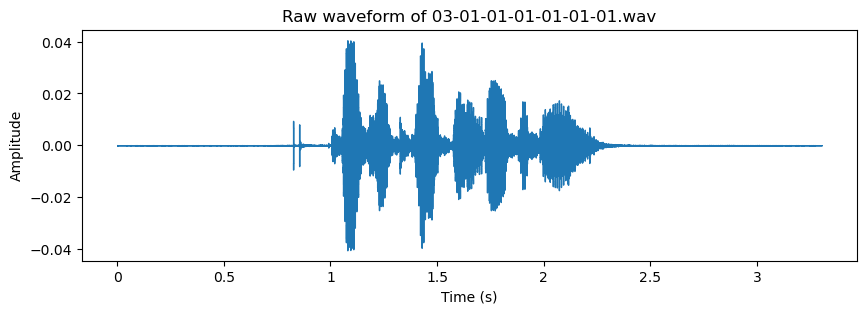

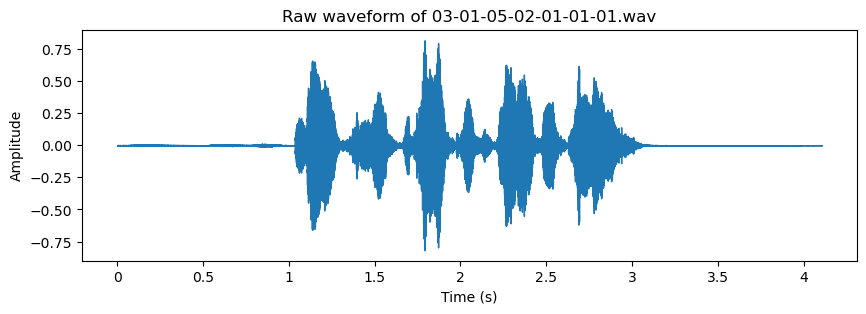

In [9]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
y1, sr = librosa.load("Ravdess/Ravdess/03-01-01-01-01-01-01.wav", sr=None)
librosa.display.waveshow(y1, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw waveform of 03-01-01-01-01-01-01.wav")
plt.show()

plt.figure(figsize=(10, 3))
y2, sr = librosa.load("Ravdess/Ravdess/03-01-05-02-01-01-01.wav", sr=None)
librosa.display.waveshow(y2, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw waveform of 03-01-05-02-01-01-01.wav")
plt.show()

Zooming in on the relevant part.

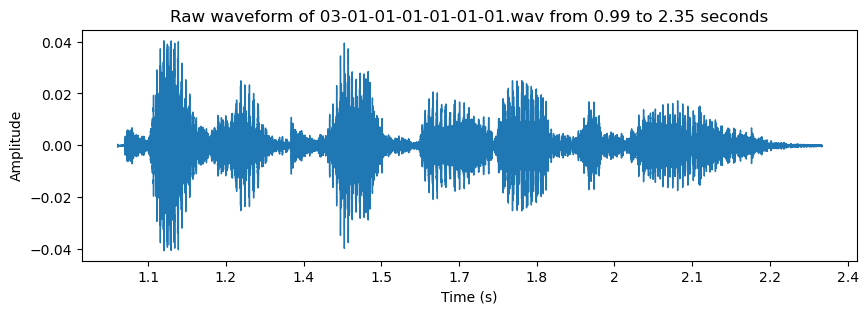

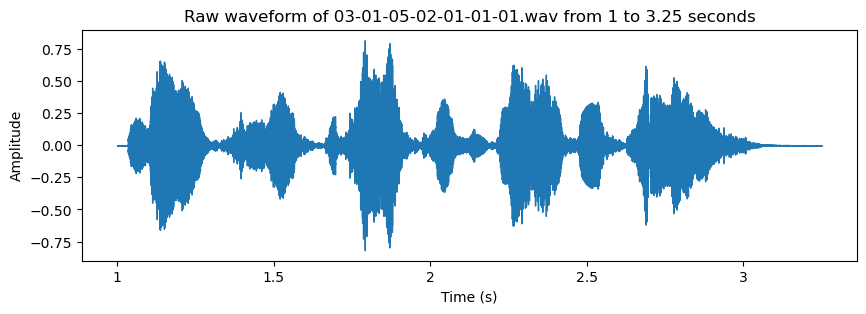

In [10]:
starting_time = 0.99
end_time = 2.35
plt.figure(figsize=(10, 3))
librosa.display.waveshow(
    y = y1[round(starting_time*SHARED_SAMPLE_RATE):round(end_time*SHARED_SAMPLE_RATE)],
    sr = sr,
    offset = starting_time)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw waveform of 03-01-01-01-01-01-01.wav from " + str(starting_time) + " to " + str(end_time) + " seconds")
plt.show()

starting_time = 1
end_time = 3.25
plt.figure(figsize=(10, 3))
librosa.display.waveshow(
    y = y2[round(starting_time*SHARED_SAMPLE_RATE):round(end_time*SHARED_SAMPLE_RATE)],
    sr = sr,
    offset = starting_time)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Raw waveform of 03-01-05-02-01-01-01.wav from " + str(starting_time) + " to " + str(end_time) + " seconds")
plt.show()    

The angry statement seems to have a considerably higher volume then the neutral statement. Let us now see if we can visualize the differences in pitch.

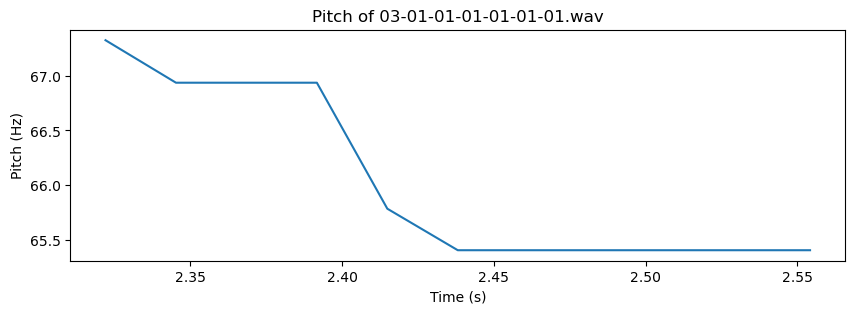

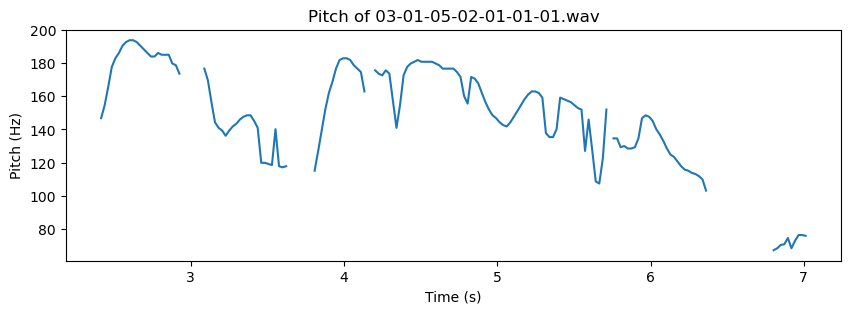

In [11]:
pitch1, voiced_flag, voiced_probs = librosa.pyin(y1, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times1 = librosa.times_like(pitch1)

plt.figure(figsize=(10, 3))
plt.plot(times1, pitch1, label='Pitch (Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title("Pitch of 03-01-01-01-01-01-01.wav")
plt.show()

pitch2, voiced_flag, voiced_probs = librosa.pyin(y2, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times2 = librosa.times_like(pitch2)

plt.figure(figsize=(10, 3))
plt.plot(times2, pitch2, label='Pitch (Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
plt.title("Pitch of 03-01-05-02-01-01-01.wav")
plt.show()

The visualization for the neutral statement does not look right, `Librosa` does not seem to correctly flag the speech. Alas, the point is that the angry statement has more variation in pitch, which is visible in the visualization. Lastly, let us see if we can show the differences in the spectrograms.

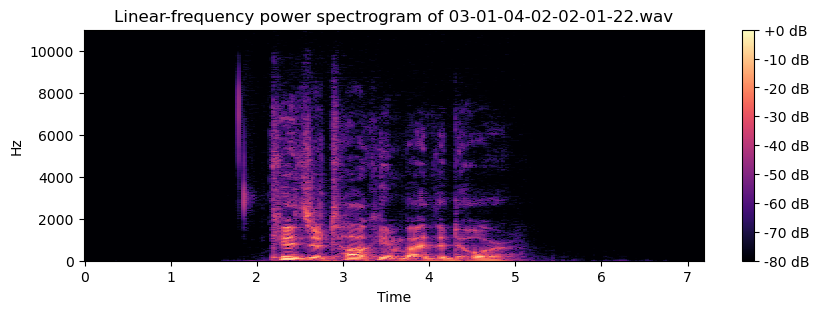

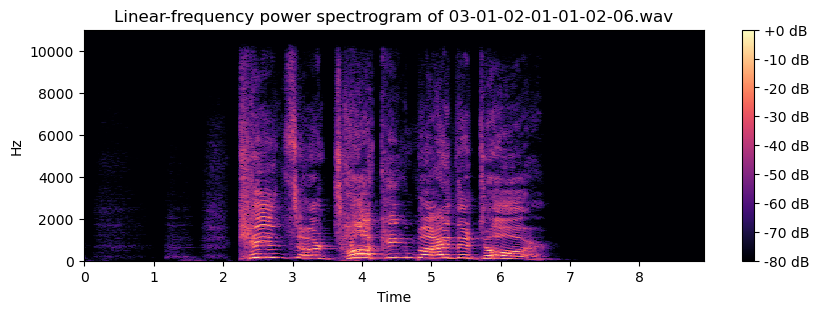

In [12]:
plt.figure(figsize=(10, 3))
y, sr = librosa.load("Ravdess/Ravdess/03-01-01-01-01-01-01.wav", sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram of ' + filenames[0])
plt.show()

plt.figure(figsize=(10, 3))
y, sr = librosa.load("Ravdess/Ravdess/03-01-05-02-01-01-01.wav", sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram of ' + filenames[1])
plt.show()

The angry statement seems to cover a wider range of frequencies than the neutral statement. This is what we would expect, as the increase in pitch and volume generates overtones that are not present in the spectrogram for the neutral statement.

---

### 3. Loading the data: ***Preparing a dataframe***

We will set a desired sample rate, this will be explained in the next section.

In [13]:
DESIRED_SAMPLE_RATE = 16000

For creating a dataframe, we will parse all audiofiles from the directory, extract the label and load the samples using the `Librosa` library. We will use the `load` function to load the audiofiles and the `resample` function to resample the audiofiles to the desired sample rate. Lastly, we will store the samples and labels in a `Pandas` dataframe.

In [14]:
import pandas as pd
import numpy as np

# load all the audio files and their labels into a dataframe
data = pd.DataFrame(columns=["audio", "label"])
audio_data = []
label_data = []

for filename in filenames:
    audio, _ = librosa.load("Ravdess/Ravdess/" + filename, sr=None)
    audio = librosa.resample(y=audio, orig_sr=SHARED_SAMPLE_RATE, target_sr=DESIRED_SAMPLE_RATE)
    label = filename.split("-")[2]
    audio_data.append(audio)
    label_data.append(label)

data["audio"] = audio_data
data["label"] = label_data

data.head()

,audio,label
0,"[-2.9334944e-07, 2.1377656e-07, -1.0903955e-07...",04
1,"[1.1922932e-05, -4.0944433e-06, 3.0186595e-05,...",02
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",02
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",05
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",03


We now have a dataframe with the samples and labels. Let us transform the labels for own readability and interpretability for the models later one.

In [15]:
print(data.label.unique())

['04' '02' '05' '03' '07' '08' '01' '06']


In [16]:
label2id = {"01": 0, "02": 1, "03": 2, "04": 3, "05": 4, "06": 5, "07": 6, "08": 7}
id2label = {v: k for k, v in label2id.items()}

data["label"] = data["label"].map(label2id)
data.head()

,audio,label
0,"[-2.9334944e-07, 2.1377656e-07, -1.0903955e-07...",3
1,"[1.1922932e-05, -4.0944433e-06, 3.0186595e-05,...",1
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


The `label2id` dictionary will be used to transform the labels to integers. The `id2label` dictionary will be used to transform the integers back to the original labels.

In [17]:
# change label2id keys to emotion names for better readability
label2id = {"neutral": 0, "calm": 1, "happy": 2, "sad": 3, "angry": 4, "fearful": 5, "disgust": 6, "surprised": 7}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

Let us check what the maximum and minimum length of the samples is.

In [18]:
# check what the min and max length of the audio files is
min_length = 1000000
max_length = 0
for audio in data["audio"]:
    if len(audio) < min_length:
        min_length = len(audio)
    if len(audio) > max_length:
        max_length = len(audio)

print("min length:", min_length)
print("max length:", max_length)

min length: 46981
max length: 84351


So the shortest audiofile is approximately 2.94 seconds. And the longest audiofile is approximately 5.27 seconds.

Let us now check the distribution of the labels.

In [19]:
data["label"].value_counts()

label
3    192
1    192
4    192
2    192
6    192
7    192
5    192
0     96
Name: count, dtype: int64

The classes are somewhat evenly distributed. Only the `neutral` class is slightly underrepresented. This is not a problem however, as the classes are still evenly distributed enough to train a model on.

---

### 4. Feature extraction

To gain relevant features for training the models I will implement a Wav2Vec2.0 model to create embeddings out of the audiofiles. The embeddings gained by this model are high dimensional vectors that (in theory) should create a semantic space in which audiofiles of each emotion get mapped close to eachother and thus are 'similar'.

The `Wav2Vec2FeatureExtractor` is a class of the `transformers` library from Hugging Face that pads and normalizes the audiosamples. It makes sure the array of audiosamples has a zero mean and unit variance. As the model was trained with samples of sample rate 16000 Hz, it is a prerequisite that the samples have the same sample rate (this is why we resampled the audiofiles).

The `Wav2Vec2Model` is a class of the `transformers` library that is pretrained on a large dataset of audiofiles. It is a large model that is trained to create embeddings of audiofiles. The model is trained to create embeddings of audiofiles of different lengths. Therefore it is perfect for our purpose.

We will use the `facebook/wav2vec2-large-xlsr-53` model. We will load the model and the feature extractor directly from `Hugging Face`.

In [20]:
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name).to(device)

print(model)

cuda


Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.bias', 'project_q.bias', 'project_q.weight', 'quantizer.weight_proj.bias', 'project_hid.weight', 'quantizer.weight_proj.weight', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

Let us see how many parameters the model has.

In [21]:
print("Total Parameters:", sum([p.numel() for p in model.parameters()]))
print("Trainable Parameters:", sum([p.numel() for p in model.parameters() if p.requires_grad]))

Total Parameters: 315438720
Trainable Parameters: 315438720


So the model has 315,438,720 parameters. This is a lot of parameters, but we will only be using the model to create embeddings of the audiofiles. We will not be (auto)training the model, so we do not have to worry about the amount of parameters.

Let's see how the model performs on a sample.

##### Model performance on a sample

From the feature extractor we get the normalized and padded samples. From the model we get the embeddings of the audiofile returned as a `pytorch` tensor.

In [22]:
i = feature_extractor(data["audio"][0], sampling_rate=DESIRED_SAMPLE_RATE, return_tensors="pt").to(device)
with torch.no_grad():
    features = model(i.input_values)

2023-10-24 16:25:02.706617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 16:25:03.655606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Let us inspect what is returned. Firstly the returned dictionary.

In [23]:
print(features.keys())

odict_keys(['last_hidden_state', 'extract_features'])


It contains the last hidden state of the model and the embeddings (extracted features) of the audiofile. Let us inspect the dimensionalities.

In [24]:
print("Shape of the last hidden state:", features.last_hidden_state.shape)
print("Shape of the extracted features:", features.extract_features.shape)

Shape of the last hidden state: torch.Size([1, 186, 1024])
Shape of the extracted features: torch.Size([1, 186, 512])


They are both 3-dimensional tensors.

The last hidden state has shape `torch.Size([batch_size, sequence_length, hidden_size])`. The `batch_size` is 1, as we only passed one audiofile. The `sequence_length` is 186, this is the time. The `hidden_size` is 1024, as this is the size of the last layer. Let us inspect the embeddings.

The extracted feature has shape `torch.Size([batch_size, sequence_length, feature_size])`. The `batch_size` is 1, as we only passed one audiofile. The `sequence_length` is 186, this is the time. The `feature_size` is 512, as this is the size of the embeddings.

In [25]:
# concatenate extract_features and last_hidden_state over time
features = torch.cat((features.last_hidden_state, features.extract_features), dim=2)
print("Shape of the concatenated tensor:", features.shape)

# take the mean over time
features = torch.mean(features, dim=1)
print("Average pooled feature:", features.shape)

# squeeze the dimension with size 1
features = torch.squeeze(features)
print("Final feature:", features.shape)

Shape of the concatenated tensor: torch.Size([1, 186, 1536])
Average pooled feature: torch.Size([1, 1536])
Final feature: torch.Size([1536])


We concatenate the last hidden state and the extracted features. As it combines high-level (last hidden state, summary-like) and intermediate-level (extracted features, detailed information from various layers) representations of the input audio data. Then we average pool over time to create a tensor of shape `[1, 1536]`. Lastly, we squeeze the tensor to create a tensor of shape `[1536]`. This is the tensor we will use as input for the models.

Let us now create a function that creates embeddings for all audiofiles in the dataframe.

##### Creating embeddings for all audiofiles

In [26]:
def extract_features(audio):
    input_values = feature_extractor(audio, sampling_rate=DESIRED_SAMPLE_RATE, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        features = model(input_values)
    features = torch.cat((features.last_hidden_state, features.extract_features), dim=2)
    features = torch.squeeze(features)
    features = torch.mean(features, dim=0)
    return features.cpu()

# extract features for all audio files
audio_features = []
for audio in data["audio"]:
    audio_features.append(extract_features(audio))

data["features"] = audio_features
data.head()

,audio,label,features
0,"[-2.9334944e-07, 2.1377656e-07, -1.0903955e-07...",3,"[tensor(-0.0324), tensor(0.2041), tensor(0.004..."
1,"[1.1922932e-05, -4.0944433e-06, 3.0186595e-05,...",1,"[tensor(-0.0322), tensor(0.2017), tensor(0.002..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[tensor(-0.0327), tensor(0.2154), tensor(0.006..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,"[tensor(-0.0320), tensor(0.2040), tensor(0.004..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,"[tensor(-0.0322), tensor(0.2045), tensor(0.002..."


In [27]:
FEATURE_DIM = len(data["features"][0])
print("Dimensionality of the feature vectors:", FEATURE_DIM)

print(data["features"][0].shape)

Dimensionality of the feature vectors: 1536
torch.Size([1536])


Now that we have embeddings for all audiofiles, we are ready to train a model.

---

### 5. Training an artificial neural network (ANN) in Torch

First, we must create a training and a testing split of the feature and label data. As the dataset is relatively small, I have chosen to create a 80-20 split. That is 80% of the dataset is used for training and 20% of the dataset is used for testing.

In [28]:
# create train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["features"], data["label"], test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1152,)
(1152,)
(288,)
(288,)


##### Dataset and dataloader

We then create a `Dataset` class that stores pairs of inputs and targets.

*Input*. The input $X$ is a 1536-dimensional feature vector as explained in the previous chapter.

*Target*. The target $y$ is one of 8 emotion labels.

We create two datasets using this class: train and test. `train_dataset` contains pairs of inputs and targets from the train split. `test_dataset` contains pairs of inputs and targets from the test split.

In [29]:
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AudioDataset(X_train.values, y_train.values)
test_dataset = AudioDataset(X_test.values, y_test.values)

Now we create dataloading objects out of the training and testing dataset. Using the `DataLoader` function from the `pytorch` library. This creates an iterable that can be used to iterate over the dataset in batches. We set the batch size to 16. This means that the `DataLoader` object will return 16 pairs of inputs and targets at a time. For the train dataloader we set shuffling to `True`. This means that the dataloader will shuffle the dataset before each epoch. This is important, as we want the model to learn to generalize and not to memorize the training data.

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

The following is some memory management code.

In [31]:
# free up memory
del model
del feature_extractor
del features
del audio_features
torch.cuda.empty_cache()

##### Model

We will create a simple ANN with 3 layers. My reasoning behind this smaller architecture is that the dataset is relatively small (only approx. 1440 samples) therefore using a larger architecture is prone to overfitting. My idea was that this smaller architecture would be able to better generalize to unseen data than a larger model.

The first layer has 1536 input nodes, as the input is a 1536-dimensional feature vector. The second layer has 128 nodes. The third layer has 8 nodes, as there are 8 emotion classes. We will use the `ReLU` activation function for the first two layers to avoid the vanishing derivative problem and the `Softmax` activation function for the last layer (this last activation is not explicitly shown in the architecture, but is included as the first step in the `CrossEntropyLoss` loss function). We will use the `CrossEntropyLoss` loss function. We will use the `AdamW` optimizer with a learning rate of 0.001 or `1e-4`.

In [32]:
# define model
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define model
class EmotionClassifier(nn.Module):
    def __init__(self, num_classes, input_features=FEATURE_DIM):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
# assign model + to GPU
model = EmotionClassifier(num_classes=len(label2id), input_features=FEATURE_DIM).to(device)
print(model)

# define optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

EmotionClassifier(
  (fc1): Linear(in_features=1536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)


#### Memory footprint 

In [33]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([128, 1536])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([64, 128])
fc2.bias 	 torch.Size([64])
fc3.weight 	 torch.Size([8, 64])
fc3.bias 	 torch.Size([8])


In [34]:
print("Model's state_dict dtypes:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].dtype)

Model's state_dict dtypes:
fc1.weight 	 torch.float32
fc1.bias 	 torch.float32
fc2.weight 	 torch.float32
fc2.bias 	 torch.float32
fc3.weight 	 torch.float32
fc3.bias 	 torch.float32


The network is fully connected, thus for the first layer the computation of it's footprint is equal to the product of the amount of input and output nodes and the output biases added:
$$(1536 \cdot 128) + 128 = 196736$$

The second layer:
$$(128 \cdot 64) + 64 = 8256$$

The third layer:
$$(64 \cdot 8) + 8 = 520$$

Total parameters:
$$196736 + 8256 + 520 = 205512$$

As all of the parameters are allocated as `torch.float32` which is 32-bits, the amount of memory the network takes up is equal to:
$$205512 \cdot 32 = 6576384$$

So 6576384 bits or about 822 Kb.

##### Training

To train the model I have written a function `train` that takes the following arguments: `dataloader`, `model`, `loss_fn`, `optimizer`. The function trains the model for one epoch and returns the average loss and accuracy for the epoch.

In [35]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0

    # iterate over dataloader
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # compute prediction error (forward pass)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss_fn(pred, y).item()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update number of correct predictions
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # print training progress
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # print training summary
    train_loss /= size
    correct /= size
    print(f"Training Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss, correct

To test the model I have written a function `test` that takes the following arguments: `dataloader`, `model`, `loss_fn`. The function tests the model and returns the average loss and accuracy for the epoch.

In [36]:
def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # forward pass (no gradient calculation)
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # print test summary
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

To put it all together, I have written a train-test loop that trains the model for a given number of epochs and tests the model after each epoch. The train-test loop returns the training and testing loss and accuracy for each epoch.

An extra functionality is the progress bar from the `tqdm` library. This shows the progress of the training and testing loop in terms of the number of epochs and the number of epochs per second.

Now we are ready to train the model.

In [37]:
from tqdm.auto import tqdm

train_loss, train_acc = [], []
test_loss, test_acc = [], []

epochs = 500
for t in tqdm(range(epochs), desc="Epochs", unit="epoch"):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, acc = train(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)
    loss, acc = test(test_dataloader, model, loss_fn)
    test_loss.append(loss)
    test_acc.append(acc)
print("Done!")

Epochs:   0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.094429  [    0/ 1152]
loss: 2.076729  [  160/ 1152]
loss: 2.075627  [  320/ 1152]
loss: 2.053066  [  480/ 1152]
loss: 2.079332  [  640/ 1152]
loss: 2.049960  [  800/ 1152]
loss: 2.031941  [  960/ 1152]
loss: 2.052062  [ 1120/ 1152]
Training Error: 
 Accuracy: 17.6%, Avg loss: 0.128793 

Test Error: 
 Accuracy: 24.7%, Avg loss: 0.126621 

Epoch 2
-------------------------------
loss: 2.046933  [    0/ 1152]
loss: 2.031630  [  160/ 1152]
loss: 2.007497  [  320/ 1152]
loss: 1.987535  [  480/ 1152]
loss: 1.951106  [  640/ 1152]
loss: 1.972217  [  800/ 1152]
loss: 1.957667  [  960/ 1152]
loss: 1.950477  [ 1120/ 1152]
Training Error: 
 Accuracy: 30.3%, Avg loss: 0.124634 

Test Error: 
 Accuracy: 31.9%, Avg loss: 0.121908 

Epoch 3
-------------------------------
loss: 1.879805  [    0/ 1152]
loss: 1.931921  [  160/ 1152]
loss: 1.902681  [  320/ 1152]
loss: 1.974713  [  480/ 1152]
loss: 1.909573  [  640/ 1152]
loss: 1.855144  [  800/ 1152]
loss

Good, the model seems to be learning. Let us plot the training and testing loss and accuracy.

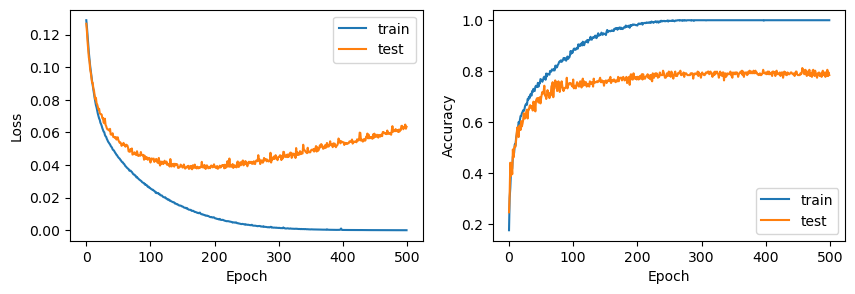

In [38]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

After approximately 200 epochs the training loss seems to approach zero and the training accuracy seems nearly perfect, the model most definitely is overfitting to the training data after this number of epochs.

Let us now see how the model performs on the test data. For visualization purposes I will create a classification report and a confusion matrix.

In [39]:
from sklearn.metrics import classification_report

model.eval()
y_pred = []

# forward pass (no gradient calculation)
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        y_pred.extend(pred.argmax(1).tolist())

print(classification_report(y_test, y_pred, target_names=label2id.keys()))

              precision    recall  f1-score   support

     neutral       0.58      0.70      0.64        20
        calm       0.94      0.76      0.84        38
       happy       0.61      0.76      0.68        29
         sad       0.76      0.63      0.69        41
       angry       0.76      0.85      0.80        33
     fearful       0.89      0.91      0.90        44
     disgust       0.77      0.83      0.80        36
   surprised       0.88      0.79      0.83        47

    accuracy                           0.78       288
   macro avg       0.77      0.78      0.77       288
weighted avg       0.80      0.78      0.79       288



The model seems to perform considerably well on the testing data. The class it seems to perform worst on is the `neutral` class. Perhaps this is related to the fact that the `neutral` class is slightly underrepresented in the dataset.

Let us plot the confusion matrix.

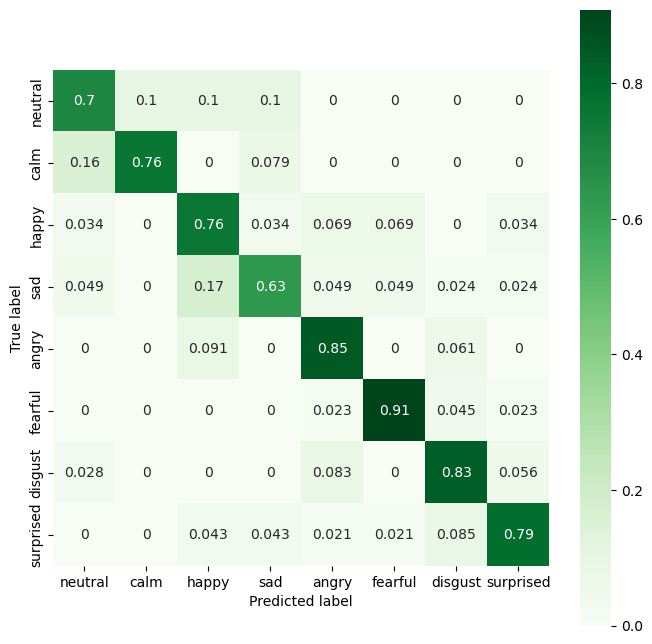

In [40]:
# create confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Greens, xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The model seems to misclassify neutral as calm and calm as neutral the most. Intuitively this makes sense, as calm and neutral are both low energy emotions. They both are signified by little variation in pitch (monotonous) and volume (low volume). But I do not see a similar effect in the results between high energy emotions, such as angry and fearful. This is interesting, as it seems that the model is able to distinguish between high energy emotions, but not as well between low energy emotions. 

Finally let us save the model.

In [41]:
# save model
path = "ANN_models/first_ANN_model.pth"

torch.save(model.state_dict(), path)
print(f"Saved PyTorch Model State to {path}")

Saved PyTorch Model State to ANN_models/first_ANN_model.pth


Perhaps we can get better results by using a different model (free lunch theorem). Let us try a Support Vector Classifier (SVC).

---

### 6. Support vector machine (SVM): ***Fitting, gridsearching and cross-validating a Support vector classifier (SVC)***

A SVM tries to map the features to a higher dimensional space in which the classes are linearly separable by hyperplanes. It's objective is to find a hyperplane that maximises the seperation distance between classes. The SVC classifies new data points based on which side of the hyperplane they fall on. I will implement this model using the `Scikit-learn` library.

First we must preprocess the data for the `sklearn` implementation. The SVC expects a 2-dimensional `numpy` array as input. We will use the same feature vector as input as we did for the ANN. We will use the same train-test split as we did for the ANN.

In [42]:
# convert X_train and y_train to numpy arrays
X_train_hat = np.array([])
y_train_hat = np.array([])

for X, y in train_dataloader:
    X_train_hat = np.append(X_train_hat, X.numpy())
    y_train_hat = np.append(y_train_hat, y.numpy())

# convert X_test and y_test to numpy arrays
X_test_hat = np.array([])
y_test_hat = np.array([])

for X, y in test_dataloader:
    X_test_hat = np.append(X_test_hat, X.numpy())
    y_test_hat = np.append(y_test_hat, y.numpy())

# reshape X_train_hat and X_test_hat
X_train_hat = X_train_hat.reshape(-1, FEATURE_DIM)
X_test_hat = X_test_hat.reshape(-1, FEATURE_DIM)

# check shapes
print(X_train_hat.shape)
print(y_train_hat.shape)
print(X_test_hat.shape)
print(y_test_hat.shape)

(1152, 1536)
(1152,)
(288, 1536)
(288,)


Let us implement a SVC with the default hyperparameters. This requires very little lines.

In [43]:
from sklearn import svm

# assign the classifier
clf = svm.SVC()

# fit the model to the training data
clf.fit(X_train_hat, y_train_hat)

SVC()

Now that it is fitted, let us see how it performs on the test data.

In [44]:
# make predictions on the test data
y_pred = clf.predict(X_test_hat)

from sklearn.metrics import accuracy_score

# print accuracy score
print("Accuracy:", accuracy_score(y_test_hat, y_pred).round(3))
print(classification_report(y_test_hat, y_pred))

Accuracy: 0.611
              precision    recall  f1-score   support

         0.0       0.38      0.40      0.39        20
         1.0       0.64      0.84      0.73        38
         2.0       0.44      0.55      0.49        29
         3.0       0.65      0.32      0.43        41
         4.0       0.65      0.67      0.66        33
         5.0       0.70      0.64      0.67        44
         6.0       0.57      0.67      0.62        36
         7.0       0.73      0.70      0.72        47

    accuracy                           0.61       288
   macro avg       0.60      0.60      0.59       288
weighted avg       0.62      0.61      0.60       288



This model does not seem to be performing better than the ANN. Perhaps we can boost performance by gridsearching the optimal parameters for the SVM and $k$-fold cross-validating while fitting.

In [45]:
from sklearn.model_selection import GridSearchCV

# these are the parameters I have tried (this takes a long time to run)
parameters = {
    'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'degree': [2, 3, 4],  # Degree for 'poly' kernel
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient for 'rbf' and 'poly'
    'class_weight': [None, 'balanced'],  # Class weights
    'decision_function_shape': ['ovr', 'ovo'],  # One-vs-Rest or One-vs-One
}

# these are the parameters I have found to be optimal
optimal_parameters = {
    'C': [100],  # Regularization parameter
    'kernel': ['rbf'],  # Kernel type
    'gamma': [0.01],  # Kernel coefficient for 'rbf' and 'poly'
}

svc = svm.SVC()
clf = GridSearchCV(svc, optimal_parameters, cv=10, n_jobs=-1)
clf.fit(X_train_hat, y_train_hat)

# print the best parameters
print("Optimal parameters:", clf.best_params_)

# make predictions on the test data
y_pred = clf.predict(X_test_hat)

print("Accuracy:", accuracy_score(y_test_hat, y_pred).round(3))
print(classification_report(y_test_hat, y_pred, target_names=label2id.keys()))

Optimal parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Accuracy: 0.847
              precision    recall  f1-score   support

     neutral       0.68      0.85      0.76        20
        calm       0.89      0.84      0.86        38
       happy       0.70      0.79      0.74        29
         sad       0.90      0.88      0.89        41
       angry       0.88      0.85      0.86        33
     fearful       0.90      0.82      0.86        44
     disgust       0.86      0.89      0.88        36
   surprised       0.89      0.85      0.87        47

    accuracy                           0.85       288
   macro avg       0.84      0.85      0.84       288
weighted avg       0.85      0.85      0.85       288



We seem to have created a model that is able to score better on the evaluation than the ANN. Let's inspect the confusion matrix and save the model for later use.

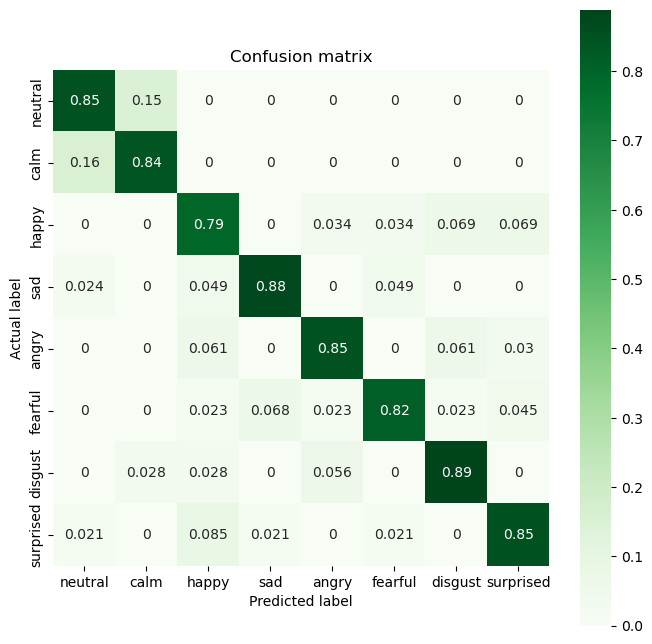

In [46]:
cm = confusion_matrix(y_test_hat, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Greens, xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix")
plt.show()

Two of the recurring misclassifications in both models are neutral being classified as calm and calm being classified as neutral. This seems to be quite a natural mistake as the difference in these emotions can be very nuanced. A similar misclassification is surpised being classified as happy.

Let us save the model.

In [47]:
# save the model
import pickle

filepath = "SVC_models/best_SVC_model.pkl"
pickle.dump(clf, open(filepath, 'wb'))
print(f"Saved model to {filepath}")

Saved model to SVC_models/best_SVC_model.pkl


---

### 7. Implementing cross-validation on the ANN

Implementing $k$-fold cross-validation whilst fitting the Support Vector Classifier seemed to considerably improve the performance of the model. In chapter 5. we also witnessed that the ANN was overfitting to the training data, perhaps implementing cross-validation for training the ANN will prevent the overfitting and improve performance on unseen data.

Firstly, a function to reset the weights of the model.

In [48]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

To implement $k$-fold cross-validation whilst fitting the ANN, we have to first re-preprocess the data. We will use the same feature vector as input as we did for the ANN. But we will now use a train-validation-test split. The train and validation splits will be concatenated and used for training the model. The test split will be used for testing the model after training. The split amounts to 80% train, 15% validation and 5% test.

In [49]:
# create train and test set
X_train, X_test, y_train, y_test = train_test_split(data["features"], data["label"], test_size=0.2, random_state=42)

# split test set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

# create dataset and dataloader
train_dataset = AudioDataset(X_train.values, y_train.values)
val_dataset = AudioDataset(X_val.values, y_val.values)
test_dataset = AudioDataset(X_test.values, y_test.values)

# create final test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

I have written a cross validation loop that for each fold takes a random number of samples from the training and validation split and trains the model on these samples for a given number of epochs. The model validated on the validation samples each epoch. The inner 'training and testing' loop returns the train and test losses and accuracies. The model is then saved and the weights are reset. The outer cross-validation loop starts again until all folds have been iterated over.

Let us now cross-validate the same ANN as in chapter 5. I have chosen for a number of 10 folds and 200 training epochs per fold, the justification behind the number of epochs is that the previous model seemed to start overfitting to the training data beyond this number of training epochs and I want the model to be able to generalize as best as possible to unseen data.

In [50]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import KFold

k_folds = 10
epochs = 200

results = {}

torch.manual_seed(42)

dataset = ConcatDataset([train_dataset, val_dataset])

kfold = KFold(n_splits=k_folds, shuffle=True)

print("Starting k-fold cross validation")
print("------------------")
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f"Fold: {fold}")
    print("------------------")

    # sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # define data loaders for training and testing data in this fold
    train_dataloader = DataLoader(
        dataset,
        batch_size=16,
        sampler=train_subsampler
    )
    val_dataloader = DataLoader(
        dataset,
        batch_size=16,
        sampler=val_subsampler
    )

    # initialize network
    model = EmotionClassifier(num_classes=len(label2id), input_features=FEATURE_DIM).to(device)
    model.apply(reset_weights)

    # initialize optimizer
    optimizer = AdamW(model.parameters(), lr=1e-4)

    # initialize lists to monitor test accuracy and loss
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []

    # training
    for t in tqdm(range(epochs), desc="Epochs", unit="epoch"):
        print(f"Epoch {t+1}\n-------------------------------")
        loss, acc = train(train_dataloader, model, loss_fn, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        loss, acc = test(val_dataloader, model, loss_fn)
        test_loss.append(loss)
        test_acc.append(acc)
    print("Done!")

    # save model
    save_path = f"kfold_models/model_{fold}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved PyTorch Model State to {save_path}")

    # save results
    results[fold] = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_loss": test_loss,
        "test_acc": test_acc
    }

    # free up memory
    del model
    del optimizer
    del train_dataloader
    del val_dataloader
    torch.cuda.empty_cache()

Starting k-fold cross validation
------------------
Fold: 0
------------------


Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.057715  [    0/ 1368]
loss: 2.062060  [  160/ 1368]
loss: 2.040793  [  320/ 1368]
loss: 2.046464  [  480/ 1368]
loss: 2.064906  [  640/ 1368]
loss: 2.031419  [  800/ 1368]
loss: 2.014472  [  960/ 1368]
loss: 2.041276  [ 1120/ 1368]
Training Error: 
 Accuracy: 16.1%, Avg loss: 0.115378 

Test Error: 
 Accuracy: 1.8%, Avg loss: 0.013161 

Epoch 2
-------------------------------
loss: 1.967818  [    0/ 1368]
loss: 1.962407  [  160/ 1368]
loss: 1.966731  [  320/ 1368]
loss: 1.966323  [  480/ 1368]
loss: 1.952444  [  640/ 1368]
loss: 1.976866  [  800/ 1368]
loss: 1.876453  [  960/ 1368]
loss: 1.930504  [ 1120/ 1368]
Training Error: 
 Accuracy: 24.5%, Avg loss: 0.110950 

Test Error: 
 Accuracy: 2.9%, Avg loss: 0.012600 

Epoch 3
-------------------------------
loss: 2.072374  [    0/ 1368]
loss: 1.928462  [  160/ 1368]
loss: 1.832438  [  320/ 1368]
loss: 1.812244  [  480/ 1368]
loss: 1.743502  [  640/ 1368]
loss: 1.930480  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.102512  [    0/ 1368]
loss: 2.045971  [  160/ 1368]
loss: 2.037961  [  320/ 1368]
loss: 2.066405  [  480/ 1368]
loss: 2.077094  [  640/ 1368]
loss: 2.008421  [  800/ 1368]
loss: 2.084776  [  960/ 1368]
loss: 2.012194  [ 1120/ 1368]
Training Error: 
 Accuracy: 18.1%, Avg loss: 0.115301 

Test Error: 
 Accuracy: 2.8%, Avg loss: 0.013369 

Epoch 2
-------------------------------
loss: 2.059266  [    0/ 1368]
loss: 1.971507  [  160/ 1368]
loss: 2.034043  [  320/ 1368]
loss: 1.993446  [  480/ 1368]
loss: 2.073684  [  640/ 1368]
loss: 1.948735  [  800/ 1368]
loss: 1.925534  [  960/ 1368]
loss: 1.968935  [ 1120/ 1368]
Training Error: 
 Accuracy: 28.6%, Avg loss: 0.110845 

Test Error: 
 Accuracy: 3.1%, Avg loss: 0.012913 

Epoch 3
-------------------------------
loss: 1.854472  [    0/ 1368]
loss: 1.911341  [  160/ 1368]
loss: 1.846802  [  320/ 1368]
loss: 1.886392  [  480/ 1368]
loss: 2.043674  [  640/ 1368]
loss: 1.945663  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.109882  [    0/ 1368]
loss: 2.093958  [  160/ 1368]
loss: 2.073658  [  320/ 1368]
loss: 2.038646  [  480/ 1368]
loss: 2.036131  [  640/ 1368]
loss: 2.046524  [  800/ 1368]
loss: 2.051452  [  960/ 1368]
loss: 2.061122  [ 1120/ 1368]
Training Error: 
 Accuracy: 15.0%, Avg loss: 0.115549 

Test Error: 
 Accuracy: 2.6%, Avg loss: 0.013228 

Epoch 2
-------------------------------
loss: 2.018349  [    0/ 1368]
loss: 2.000119  [  160/ 1368]
loss: 2.050164  [  320/ 1368]
loss: 2.010704  [  480/ 1368]
loss: 2.001057  [  640/ 1368]
loss: 2.034047  [  800/ 1368]
loss: 1.995083  [  960/ 1368]
loss: 1.951227  [ 1120/ 1368]
Training Error: 
 Accuracy: 24.6%, Avg loss: 0.111642 

Test Error: 
 Accuracy: 3.7%, Avg loss: 0.012616 

Epoch 3
-------------------------------
loss: 2.006655  [    0/ 1368]
loss: 1.811863  [  160/ 1368]
loss: 1.910037  [  320/ 1368]
loss: 1.920722  [  480/ 1368]
loss: 1.932142  [  640/ 1368]
loss: 1.776297  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.104442  [    0/ 1368]
loss: 2.106797  [  160/ 1368]
loss: 2.085211  [  320/ 1368]
loss: 2.038358  [  480/ 1368]
loss: 2.079867  [  640/ 1368]
loss: 2.073544  [  800/ 1368]
loss: 2.065002  [  960/ 1368]
loss: 2.029294  [ 1120/ 1368]
Training Error: 
 Accuracy: 17.3%, Avg loss: 0.116151 

Test Error: 
 Accuracy: 3.0%, Avg loss: 0.013383 

Epoch 2
-------------------------------
loss: 1.993729  [    0/ 1368]
loss: 2.016838  [  160/ 1368]
loss: 2.068765  [  320/ 1368]
loss: 1.967241  [  480/ 1368]
loss: 1.997682  [  640/ 1368]
loss: 1.964396  [  800/ 1368]
loss: 2.030543  [  960/ 1368]
loss: 2.009012  [ 1120/ 1368]
Training Error: 
 Accuracy: 26.6%, Avg loss: 0.112529 

Test Error: 
 Accuracy: 3.7%, Avg loss: 0.012977 

Epoch 3
-------------------------------
loss: 2.033705  [    0/ 1368]
loss: 1.964150  [  160/ 1368]
loss: 1.853495  [  320/ 1368]
loss: 1.935935  [  480/ 1368]
loss: 1.930259  [  640/ 1368]
loss: 1.929463  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.148978  [    0/ 1368]
loss: 2.082102  [  160/ 1368]
loss: 2.074523  [  320/ 1368]
loss: 2.075773  [  480/ 1368]
loss: 2.034682  [  640/ 1368]
loss: 2.055943  [  800/ 1368]
loss: 2.047780  [  960/ 1368]
loss: 2.040526  [ 1120/ 1368]
Training Error: 
 Accuracy: 15.3%, Avg loss: 0.115506 

Test Error: 
 Accuracy: 2.0%, Avg loss: 0.013250 

Epoch 2
-------------------------------
loss: 2.030480  [    0/ 1368]
loss: 2.047881  [  160/ 1368]
loss: 1.951514  [  320/ 1368]
loss: 1.963780  [  480/ 1368]
loss: 1.951692  [  640/ 1368]
loss: 1.919972  [  800/ 1368]
loss: 1.916440  [  960/ 1368]
loss: 1.910995  [ 1120/ 1368]
Training Error: 
 Accuracy: 25.3%, Avg loss: 0.110896 

Test Error: 
 Accuracy: 2.9%, Avg loss: 0.012668 

Epoch 3
-------------------------------
loss: 1.808839  [    0/ 1368]
loss: 1.873289  [  160/ 1368]
loss: 1.909395  [  320/ 1368]
loss: 1.929814  [  480/ 1368]
loss: 1.896094  [  640/ 1368]
loss: 1.793160  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.107906  [    0/ 1368]
loss: 2.088936  [  160/ 1368]
loss: 2.043911  [  320/ 1368]
loss: 2.064537  [  480/ 1368]
loss: 2.018507  [  640/ 1368]
loss: 2.067132  [  800/ 1368]
loss: 2.004827  [  960/ 1368]
loss: 2.001374  [ 1120/ 1368]
Training Error: 
 Accuracy: 15.0%, Avg loss: 0.115234 

Test Error: 
 Accuracy: 2.3%, Avg loss: 0.013130 

Epoch 2
-------------------------------
loss: 2.000654  [    0/ 1368]
loss: 2.032920  [  160/ 1368]
loss: 2.056452  [  320/ 1368]
loss: 2.011522  [  480/ 1368]
loss: 1.944772  [  640/ 1368]
loss: 1.963392  [  800/ 1368]
loss: 1.988670  [  960/ 1368]
loss: 1.969645  [ 1120/ 1368]
Training Error: 
 Accuracy: 23.0%, Avg loss: 0.110887 

Test Error: 
 Accuracy: 2.9%, Avg loss: 0.012542 

Epoch 3
-------------------------------
loss: 1.852212  [    0/ 1368]
loss: 1.861625  [  160/ 1368]
loss: 1.875849  [  320/ 1368]
loss: 1.904621  [  480/ 1368]
loss: 1.946233  [  640/ 1368]
loss: 1.906045  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.105884  [    0/ 1368]
loss: 2.079287  [  160/ 1368]
loss: 2.090079  [  320/ 1368]
loss: 2.068751  [  480/ 1368]
loss: 2.061584  [  640/ 1368]
loss: 2.031376  [  800/ 1368]
loss: 1.995536  [  960/ 1368]
loss: 2.035322  [ 1120/ 1368]
Training Error: 
 Accuracy: 17.3%, Avg loss: 0.115125 

Test Error: 
 Accuracy: 1.8%, Avg loss: 0.013356 

Epoch 2
-------------------------------
loss: 1.992045  [    0/ 1368]
loss: 1.989164  [  160/ 1368]
loss: 1.961666  [  320/ 1368]
loss: 2.024207  [  480/ 1368]
loss: 2.048154  [  640/ 1368]
loss: 1.963145  [  800/ 1368]
loss: 2.030897  [  960/ 1368]
loss: 1.905713  [ 1120/ 1368]
Training Error: 
 Accuracy: 26.1%, Avg loss: 0.110194 

Test Error: 
 Accuracy: 3.6%, Avg loss: 0.012727 

Epoch 3
-------------------------------
loss: 1.825918  [    0/ 1368]
loss: 1.847165  [  160/ 1368]
loss: 1.954713  [  320/ 1368]
loss: 1.872554  [  480/ 1368]
loss: 1.735422  [  640/ 1368]
loss: 1.871678  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.095474  [    0/ 1368]
loss: 2.089550  [  160/ 1368]
loss: 2.069174  [  320/ 1368]
loss: 2.057590  [  480/ 1368]
loss: 2.043105  [  640/ 1368]
loss: 2.013371  [  800/ 1368]
loss: 2.040362  [  960/ 1368]
loss: 2.086099  [ 1120/ 1368]
Training Error: 
 Accuracy: 16.7%, Avg loss: 0.115390 

Test Error: 
 Accuracy: 2.9%, Avg loss: 0.013163 

Epoch 2
-------------------------------
loss: 1.996996  [    0/ 1368]
loss: 1.883189  [  160/ 1368]
loss: 2.001774  [  320/ 1368]
loss: 1.970877  [  480/ 1368]
loss: 1.988943  [  640/ 1368]
loss: 1.939615  [  800/ 1368]
loss: 1.825186  [  960/ 1368]
loss: 1.920180  [ 1120/ 1368]
Training Error: 
 Accuracy: 27.9%, Avg loss: 0.109525 

Test Error: 
 Accuracy: 3.5%, Avg loss: 0.012502 

Epoch 3
-------------------------------
loss: 1.853226  [    0/ 1368]
loss: 1.819779  [  160/ 1368]
loss: 1.752427  [  320/ 1368]
loss: 1.881679  [  480/ 1368]
loss: 1.950071  [  640/ 1368]
loss: 2.050596  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.080175  [    0/ 1368]
loss: 2.067626  [  160/ 1368]
loss: 2.067631  [  320/ 1368]
loss: 2.087098  [  480/ 1368]
loss: 2.000672  [  640/ 1368]
loss: 2.025714  [  800/ 1368]
loss: 2.034703  [  960/ 1368]
loss: 2.005333  [ 1120/ 1368]
Training Error: 
 Accuracy: 14.5%, Avg loss: 0.115441 

Test Error: 
 Accuracy: 2.0%, Avg loss: 0.013300 

Epoch 2
-------------------------------
loss: 2.047754  [    0/ 1368]
loss: 1.985070  [  160/ 1368]
loss: 1.954809  [  320/ 1368]
loss: 1.955327  [  480/ 1368]
loss: 1.929898  [  640/ 1368]
loss: 1.975296  [  800/ 1368]
loss: 1.881515  [  960/ 1368]
loss: 1.955521  [ 1120/ 1368]
Training Error: 
 Accuracy: 28.5%, Avg loss: 0.110994 

Test Error: 
 Accuracy: 3.1%, Avg loss: 0.012797 

Epoch 3
-------------------------------
loss: 1.895939  [    0/ 1368]
loss: 1.848088  [  160/ 1368]
loss: 1.861994  [  320/ 1368]
loss: 1.884822  [  480/ 1368]
loss: 1.945528  [  640/ 1368]
loss: 1.915460  [  800/ 1368]
loss: 

Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1
-------------------------------
loss: 2.087134  [    0/ 1368]
loss: 2.060118  [  160/ 1368]
loss: 2.104403  [  320/ 1368]
loss: 2.036149  [  480/ 1368]
loss: 2.075536  [  640/ 1368]
loss: 2.038963  [  800/ 1368]
loss: 2.019959  [  960/ 1368]
loss: 1.986950  [ 1120/ 1368]
Training Error: 
 Accuracy: 13.5%, Avg loss: 0.115557 

Test Error: 
 Accuracy: 1.8%, Avg loss: 0.013326 

Epoch 2
-------------------------------
loss: 2.054477  [    0/ 1368]
loss: 1.945637  [  160/ 1368]
loss: 2.000871  [  320/ 1368]
loss: 2.006174  [  480/ 1368]
loss: 1.948360  [  640/ 1368]
loss: 1.985370  [  800/ 1368]
loss: 1.978934  [  960/ 1368]
loss: 1.957579  [ 1120/ 1368]
Training Error: 
 Accuracy: 21.4%, Avg loss: 0.110638 

Test Error: 
 Accuracy: 2.2%, Avg loss: 0.012762 

Epoch 3
-------------------------------
loss: 1.959743  [    0/ 1368]
loss: 1.838997  [  160/ 1368]
loss: 1.905450  [  320/ 1368]
loss: 1.860356  [  480/ 1368]
loss: 1.822050  [  640/ 1368]
loss: 1.786860  [  800/ 1368]
loss: 

Good, it seems to have worked. Let us plot the training and testing loss and accuracy.

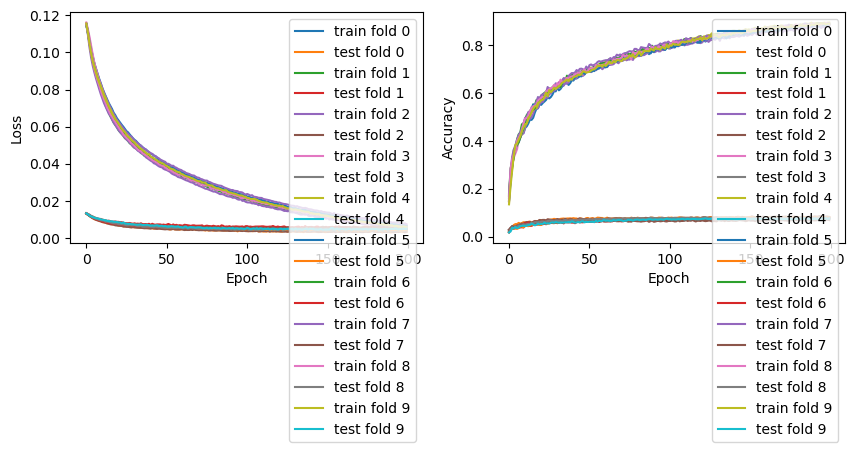

K-FOLD CROSS VALIDATION RESULTS FOR 10 FOLDS
--------------------------------
Fold 0: Train acc: 0.887, Test acc: 0.081
Fold 1: Train acc: 0.885, Test acc: 0.076
Fold 2: Train acc: 0.885, Test acc: 0.082
Fold 3: Train acc: 0.887, Test acc: 0.082
Fold 4: Train acc: 0.895, Test acc: 0.076
Fold 5: Train acc: 0.888, Test acc: 0.080
Fold 6: Train acc: 0.890, Test acc: 0.077
Fold 7: Train acc: 0.893, Test acc: 0.069
Fold 8: Train acc: 0.889, Test acc: 0.075
Fold 9: Train acc: 0.890, Test acc: 0.077
Average Test Accuracy: 0.077
Best fold: 2
Best accuracy: 0.08187134502923976


EmotionClassifier(
  (fc1): Linear(in_features=1536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)

In [51]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)

for fold in range(k_folds):
    plt.plot(results[fold]["train_loss"], label=f"train fold {fold}")
    plt.plot(results[fold]["test_loss"], label=f"test fold {fold}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
for fold in range(k_folds):
    plt.plot(results[fold]["train_acc"], label=f"train fold {fold}")
    plt.plot(results[fold]["test_acc"], label=f"test fold {fold}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    train_acc = value['train_acc'][-1]
    test_acc = value['test_acc'][-1]
    sum += test_acc
    print(f'Fold {key}: Train acc: {train_acc:.3f}, Test acc: {test_acc:.3f}')
print(f'Average Test Accuracy: {sum/len(results):.3f}')

# find the best model
best_fold = 0
best_acc = 0
for fold, result in results.items():
    if result["test_acc"][-1] > best_acc:
        best_fold = fold
        best_acc = result["test_acc"][-1]

print(f"Best fold: {best_fold}")
print(f"Best accuracy: {best_acc}")

# load the best model
model = EmotionClassifier(num_classes=len(label2id), input_features=FEATURE_DIM).to(device)
model.load_state_dict(torch.load(f"kfold_models/model_{best_fold}.pth"))
model.eval()

The validation accuracy seems to have gone up slightly from before. Let us see how well this 'best' model performs on unseen data.

In [52]:
# print the classification report
y_pred = []
y_true = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        y_pred.extend(pred.argmax(1).tolist())
        y_true.extend(y.tolist())

print(classification_report(y_true, y_pred, target_names=label2id.keys()))

              precision    recall  f1-score   support

     neutral       0.55      0.75      0.63         8
        calm       0.88      0.70      0.78        10
       happy       0.78      0.78      0.78         9
         sad       0.78      0.64      0.70        11
       angry       0.89      0.80      0.84        10
     fearful       1.00      0.67      0.80         9
     disgust       0.60      0.75      0.67         8
   surprised       0.70      1.00      0.82         7

    accuracy                           0.75        72
   macro avg       0.77      0.76      0.75        72
weighted avg       0.78      0.75      0.75        72



This is not too bad. The model seems to generalize well to unseen data. Though the recall of 1.0 on the surprised class does not seem very representative of the model's true performance, perhaps this is because of the low amount of testing samples.

Let us plot the confusion matrix. 

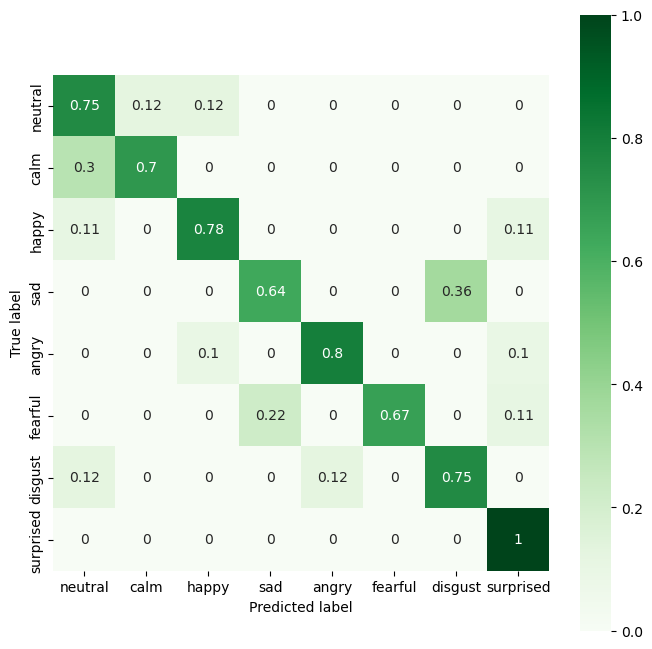

In [53]:
# create confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, square=True, cmap=plt.cm.Greens, xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Once again we see the recurring misclassifications of neutral being classified as calm and calm being classified as neutral. But also some unexpected misclassifications such as sad being classified as disgust. This is unexpected as I would intuitively describe sad as a low energy emotion and disgust as a high energy emotion.

---

### 8. Discussion

##### Summary of methods

In this paper I have explored a variety of automated methods for feature extraction and classification of emotion in audible speech data. I have implemented a Wav2Vec 2.0 feature extractor and embed the audiofiles using this large model. I have passed these embeddings through as input to a three-layer artificial neural network (ANN) that is trained and tested on approximately 1400 labeled recordings. I have compared the performance of the ANN with that of a Support Vector Classifier (SVC) and that of the same ANN trained with 10-fold cross-validation.

##### Summary of results

The ANN had a validation accuracy of approximately 81% but seemed to be overfitting to the training data. The SVC had a testing accuracy of approximately 85% and seemed to be performing better than the ANN. The ANN trained with 10-fold cross-validation had a validation accuracy of approximately 84% and seemed to be performing better than the ANN trained without cross-validation.

Overall the SVC seemed to be performing best.

##### Limitations

The dataset is relatively small, only 1440 audiofiles. This is not a lot of data to train a model on. This is especially true for the ANN, as it has a lot of parameters to train. This is also true for the SVC, but it seems to pick up on the most important patterns in the data better than the ANN.

The dataset is also not very diverse. It only contains the same two spoken sentences. This means there is probably not a lot of variation in the data and the model will not be able to generalize well to unseen data such as different sentences.

##### Future improvements

Enlarging the dataset would be a good first step. This would allow for more variation in the data and would allow the model to generalize better to unseen data.

Another improvement would be using a long short-term memory (LSTM) model to create a single memory state of the embeddings. Now we have implemented average pooling over time, but this means a lot of valuable information in the sequential nature of the data is lost as the mean does not account for the order of the sequence. An LSTM model would be able to create a single memory state of the embeddings that does account for the order of the sequence.

Lastly, the method of feature extraction could be compared to other methods of feature extraction. For example, the Mel-frequency cepstral coefficients (MFCCs) method. This method is based on the logarithmic mel scale of human hearing. It is a method that is often used for speech recognition and speech emotion recognition.

##### To what extent can we answer the specific research question?

I am able to answer this question: Yes, I have built a model that has learned to correctly distinguishes recordings of a certain emotion class from other classes. The SVC seems to be performing best.

##### To what extent can we answer the general research question?

My general research question for this paper is: is it possible to distinguish various emotions from an audio recording of speech?

I am able to answer this question in a limited way as discussed in the limitations: Yes, it is possible to distinguish various emotions from *these specific* audio recording of speech. However we do not know if the model will generalize to other audio recordings of speech such as different sentences.

---

### 9. Conclusion

This paper explored a variety of automated methods for feature extraction and classification of emotion in audible speech data.

I implemented a Wav2Vec 2.0 feature extractor and embed the audiofiles using this large model. I passed these embeddings through as input to a three-layer artificial neural network (ANN) that is trained and tested on approximately 1400 labeled recordings. I compared the performance of the ANN with that of a Support Vector Classifier (SVC) and that of the same ANN trained with 10-fold cross-validation. The SVC seemed to be performing best.

Some limitations of the paper were the small and not very diverse dataset. Some future improvements would be enlarging and diversifying the dataset, using a long short-term memory (LSTM) model to create a single memory state of the embeddings and comparing the method of feature extraction to other methods of feature extraction.

---

### References

Livingstone, S. R., & Russo, F. A. (2018). The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) (1.0.0) [dataset]. Zenodo. https://doi.org/10.5281/ZENODO.1188975